In [2]:
from datetime import datetime as dt
print(dt.now())

2018-07-25 23:48:19.163644


### 0 - Import Packages, Modules. Define Functions

In [3]:
#Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

#For ML Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

#For NLP
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word

#For Exploratory Data Analysis
%run '../../../Functions/Exploratory Data Analysis Function.ipynb'

In [4]:
#Define function to cross validate model using a particular vectorizer
def cross_validation(X, y, classifier_type, vect_type, print_metrics = True):
    kf = model_selection.KFold(n_splits = 10, shuffle = True)
    scores = []
    confusion_matrix_array = np.array([[0,0],[0,0]])
    classification_report_list = []
    metrics_dict = {}
    
    for train_index, test_index in kf.split (X, y):
        model = classifier_type

        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        X_train_dtm = vect_type.fit_transform(X_train)
        X_test_dtm = vect_type.transform(X_test)
        
        model = model.fit(X_train_dtm, y.iloc[train_index])
        y_pred = model.predict(X_test_dtm)
        
        #Compute testing accuracy for each fold and append to scores list
        testing_accuracy = metrics.accuracy_score(y.iloc[test_index], y_pred)
        scores.append(testing_accuracy)
        
        #Produce and add to confusion matrix for each fold
        confusion_matrix_array += confusion_matrix(y.iloc[test_index], y_pred)
        
        #Produce classification report and append to classification report list
        classification_report_list.append(precision_recall_fscore_support(y.iloc[test_index], y_pred)) 
    
    metrics_dict['average_accuracy'] = np.mean(scores)
    metrics_dict['confusion_matrix_sum'] = confusion_matrix_array
    metrics_dict['average_classification_report'] = pd.DataFrame(np.array(np.mean(classification_report_list, axis = 0))[0:3], index = ['precision', 'recall', 'fl-score']).T
    
    if print_metrics == True:
        print(str(model) + ' Metric Report')
        print('\n -- Accuracy -- ')
        print(metrics_dict['average_accuracy'])
        print('\n -- Confusion Matrix -- ')
        print(metrics_dict['confusion_matrix_sum'])
        print('\n -- Classification Report -- ')
        print(metrics_dict['average_classification_report'])
        print('\nNote: we do not print the average "support" values as it is meaningless. We need to refer to the confusion matrix sum above')
    return(metrics_dict)

### 1 - Load Data and Exploratory Analysis

In [5]:
raw_data = pd.read_csv("SMSSpamCollection.tsv",sep='\t',names=['label','text'])
pd.set_option('display.max_colwidth',100)

In [6]:
data_summary(raw_data)

########## START OF DATA SUMMARY ##########
(i) SHAPE
Rows and Columns: (5572, 2)

(ii) GLIMPSE OF HEAD
  label  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                  text  
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...  
1                                                                        Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  
3                                                    U dun say so early hor... U c already then say...  
4                                        Nah I don't think he goes to usf, he lives around here though  

(iii) DATA TYPES
label    object
text     object
dtype: object

(iv - a) SUMMARY STATISTICS OF NUMERIC VALUES
No numeric columns

(iv - b) SUMMARY STATISTICS OF CAT/STRING VALUES
       label       

'######### END OF DATA SUMMARY ########## '

#### Observations:
#### 1) There two columns, one containing the text messages and one containing a label that indicates whether or not the text message is spam. We need to convert the label column to integers. 
#### 2) There seem to be a lot of slang words associated with certain countries in some of the text messages
#### 3) There are no missing values in either column. 
#### 4) There are duplicate rows in the dataset. We need to remove these. 
#### 5) Since this is a text-based classification problem, suitable candidate machine learning models are naive bayes, decision tree and random forest. KNN, SVM and logistic regression models, while typically used for two-class classification problems are not suitable to be applied to text-based problems. 

### 2 - Data Cleaning

In [7]:
#---- Drop duplicates from dataframe  ----
raw_data_clean = raw_data
raw_data_clean.drop_duplicates(inplace = True)

#---- Convert label column from string to integers. ham = 0, spam = 1  ----
raw_data_clean.loc[raw_data_clean['label'] == 'ham', 'label'] = 0
raw_data_clean.loc[raw_data_clean['label'] == 'spam', 'label'] = 1

#----- Look at summary of clean data to verify all changes were made correctly -----
data_summary(raw_data_clean)

########## START OF DATA SUMMARY ##########
(i) SHAPE
Rows and Columns: (5169, 2)

(ii) GLIMPSE OF HEAD
  label  \
0     0   
1     0   
2     1   
3     0   
4     0   

                                                                                                  text  
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...  
1                                                                        Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  
3                                                    U dun say so early hor... U c already then say...  
4                                        Nah I don't think he goes to usf, he lives around here though  

(iii) DATA TYPES
label    object
text     object
dtype: object

(iv - a) SUMMARY STATISTICS OF NUMERIC VALUES
No numeric columns

(iv - b) SUMMARY STATISTICS OF CAT/STRING VALUES
        label  \
co

'######### END OF DATA SUMMARY ########## '

### 3 - Define Predictor Variables and Outcome

In [8]:
X = raw_data_clean.text
y = raw_data_clean.label
y[y == 'ham'] = 0
y[y == 'spam'] = 1
y = pd.to_numeric(y)

### 3 - Feature Engineering on Text Column

In [9]:
vect_list = []

#### (i) Standard CountVectorizer

In [10]:
#First, determine if preserving capitalization is important
vect = CountVectorizer(lowercase = False)
X_vect1 = vect.fit_transform(X)
X_names =  vect.get_feature_names()
X_isupper = list(map(lambda x: x.isupper(), X_names))
print([x for x, y in zip(X_names, X_isupper) if y == True])

['0796XXXXXX', '07XXXXXXXXX', '0A', '1000CALL', '10K', '14TCR', '150P', '150P16', '150PPM', '1DA', '1ER', '1IM', '1YF', '20M12AQ', '23F', '23G', '24M', '2B', '2C', '2DOCD', '2EZ', '2GETHA', '2GEVA', '2I', '2MORO', '2MOROW', '2MORRO', '2MRW', '2MWEN', '2NITE', '2PX', '2U', '2WATERSHD', '2WT', '2WU', '3AJ', '3D', '3G', '3GBP', '3LP', '3MOBILE', '3POUND', '3SS', '3UZ', '3XX', '40GB', '4403LDNW1A7RW18', '4BREKKIE', '4EVA', '4GET', '4JX', '4MY', '4QF2', '4T', '4U', '4WARD', '5K', '5WB', '5WE', '5WQ', '60P', '6HL', '6WU', '6ZF', '7MP', '7WS', '7ZS', '8WP', '92H', '97N7QP', '9AE', '9YT', 'A21', 'ABOUT', 'ABOUTAS', 'ABTA', 'ACCEPT', 'ACL03530150PM', 'ACTION', 'ACTUALLY', 'AD', 'ADAM', 'ADDAMSFA', 'ADP', 'ADRINK', 'AFEW', 'AFTER', 'AFTERNOON', 'AG', 'AGAIN', 'AGAINST', 'AGE', 'AGES', 'AGO', 'AH', 'AIG', 'AINT', 'AL', 'ALERT', 'ALETTER', 'ALEX', 'ALL', 'ALRITE', 'ALSO', 'ALWAYS', 'AM', 'AMY', 'AN', 'ANAL', 'AND', 'ANNIE', 'ANS', 'ANSWER', 'ANTELOPE', 'ANYTHING', 'ANYWAY', 'AOM', 'APPY', 'APRIL',

#### Does not look like capitalization matters here. The list contains both random words and actual words. 

In [11]:
vect_count = CountVectorizer()
vect_list.append(vect_count)

#### (ii) N-grams

In [12]:
# Include 1-grams and 2-grams.
vect_ngram = CountVectorizer(ngram_range=(1, 2))
vect_list.append(vect_ngram)

#### (iii) Stop-Word Removal

In [13]:
vect_stop = CountVectorizer(stop_words='english')
vect_list.append(vect_stop)

#### (iv) Stemming

In [14]:
stemmer = SnowballStemmer('english')

# Define a function that accepts text and returns a list of stems.
def split_into_stems(text):
    text = str(text).lower()
    words = TextBlob(text).words
    return [stemmer.stem(word) for word in words]

In [15]:
vect_stem = CountVectorizer(analyzer = split_into_stems, decode_error = 'replace')
vect_list.append(vect_stem)

In [16]:
# Check % of words root was found for (based on grouping)
X_stem_check = vect_stem.fit_transform(X)
X_count_check = vect_count.fit_transform(X)
stem_list = vect_stem.get_feature_names()
count_list = vect_count.get_feature_names()
1 - (np.setdiff1d(stem_list, count_list).shape[0] / X.shape[0])

0.424646933642871

#### (v) Lemmatization

In [17]:
# Define a function that accepts text and returns a list of lemmas.
def split_into_lemmas(text):
    text = str(text).lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [18]:
vect_lemm = CountVectorizer(analyzer = split_into_lemmas, decode_error='replace')
vect_list.append(vect_lemm)

In [19]:
# Check % of words root was found for
X_lemm_check = vect_lemm.fit_transform(X)
X_count_check = vect_count.fit_transform(X)
lemm_list = vect_lemm.get_feature_names()
count_list = vect_count.get_feature_names()
1 - (np.setdiff1d(lemm_list, count_list).shape[0] / X.shape[0])

0.7283807312826465

#### The lemmatizer was able to find the root for 72% of the words in the text messages. On the other stemmer was only able to find common groups for 42% of the words. The % of words in its original form is significant in both cases. 

### 3 - Train Candidate Machine Learning Models
#### We use a pre-defined cross_validation function to train each candidate model and assess its accuracy. The function returns three outputs that we can use to assess the accuracy of the model: 
#### 1) Testing accuracy: The % of classification labels that the model was able to predict correctly using the test data. The higher this number is, the more accurate the model is deemed to be. Since the cross_validation function runs training and testing for 10 data folds, this value is an average of 10 testing accuracy values. 
#### 2) Confusion matrix: This matrix reports (L-R) the true negatives, false negatives, false positives and true positives predicted by the model. The higher the numbers across the diagonal, the better the model performs. Since the cross_validation function runs training and testing for 10 data folds, this value is the sum of confusion matrices across the 10 folds. Why is a confusion matrix useful? While the overall accuracy is a good indicator of model performance, it is also important to assess how well the model is able to predict specific outcomes. In this case, it is important that our model can successfully predict the existence of relationships between devices. So, we want our model to have a high true positive count. 
#### 3) Classification report: Finally, the recall percentages in the classification report for each model translates the percentage of true negatives and positives the model was able to classify. Again, we are going for a high recall percentage for class 1. "

#### Now, start training each model on the data. For each model, we are trying to optimize for two things: 1) relevant hyperparameters 2) the vectorizer type 
#### (i) Multinomial Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB
#Determine optimal alpha (smoothing) value and vectorizer type
alpha_range = np.arange(0.1, 1, 0.1)
count = 0
accuracy_dict = {}
for i in range(len(vect_list)):
    for j in alpha_range:
        print('~~~~ Iter' + str(count+1) + ' Cross Validating for vect type: ' + str(i+1) + ' and alpha: ' + str(j) + '~~~~')
        accuracy_dict[count] = cross_validation(X, y, MultinomialNB(alpha = j), vect_type = vect_list[i], print_metrics = False)['average_accuracy']
        count += 1

~~~~ Iter1 Cross Validating for vect type: 1 and alpha: 0.1~~~~
~~~~ Iter2 Cross Validating for vect type: 1 and alpha: 0.2~~~~
~~~~ Iter3 Cross Validating for vect type: 1 and alpha: 0.30000000000000004~~~~
~~~~ Iter4 Cross Validating for vect type: 1 and alpha: 0.4~~~~
~~~~ Iter5 Cross Validating for vect type: 1 and alpha: 0.5~~~~
~~~~ Iter6 Cross Validating for vect type: 1 and alpha: 0.6~~~~
~~~~ Iter7 Cross Validating for vect type: 1 and alpha: 0.7000000000000001~~~~
~~~~ Iter8 Cross Validating for vect type: 1 and alpha: 0.8~~~~
~~~~ Iter9 Cross Validating for vect type: 1 and alpha: 0.9~~~~
~~~~ Iter10 Cross Validating for vect type: 2 and alpha: 0.1~~~~
~~~~ Iter11 Cross Validating for vect type: 2 and alpha: 0.2~~~~
~~~~ Iter12 Cross Validating for vect type: 2 and alpha: 0.30000000000000004~~~~
~~~~ Iter13 Cross Validating for vect type: 2 and alpha: 0.4~~~~
~~~~ Iter14 Cross Validating for vect type: 2 and alpha: 0.5~~~~
~~~~ Iter15 Cross Validating for vect type: 2 and al

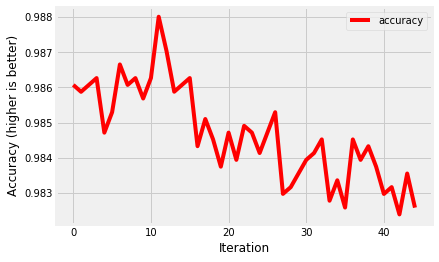

In [21]:
#Plot accuracy against max depth value
accuracy_matrix = pd.DataFrame.from_dict(accuracy_dict, orient='index')
accuracy_matrix.columns = ['accuracy']
accuracy_matrix.plot(color = 'red');
plt.xlabel('Iteration');
plt.ylabel('Accuracy (higher is better)');

In [22]:
naive_bayes_model = cross_validation(X, y, MultinomialNB(alpha = 0.1), vect_type = vect_list[1])

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True) Metric Report

 -- Accuracy -- 
0.9856847795120928

 -- Confusion Matrix -- 
[[4483   33]
 [  41  612]]

 -- Classification Report -- 
   precision    recall  fl-score
0   0.990915  0.992694  0.991794
1   0.948150  0.937608  0.942372

Note: we do not print the average "support" values as it is meaningless. We need to refer to the confusion matrix sum above


#### (ii) Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

#Determine optimal max_depth value and vectorizer type
depth_range = range(3, 21, 1)
count = 0
accuracy_dict = {}
for i in range(len(vect_list)):
    for j in depth_range:
        print('~~~~ Iter' + str(count+1) + ' Cross Validating for vect type: ' + str(i+1) + ' and max_depth: ' + str(j) + '~~~~')
        accuracy_dict[count] = cross_validation(X, y, DecisionTreeClassifier(max_depth = j), vect_type = vect_list[i], print_metrics = False)['average_accuracy']
        count += 1

~~~~ Iter1 Cross Validating for vect type: 1 and max_depth: 3~~~~
~~~~ Iter2 Cross Validating for vect type: 1 and max_depth: 4~~~~
~~~~ Iter3 Cross Validating for vect type: 1 and max_depth: 5~~~~
~~~~ Iter4 Cross Validating for vect type: 1 and max_depth: 6~~~~
~~~~ Iter5 Cross Validating for vect type: 1 and max_depth: 7~~~~
~~~~ Iter6 Cross Validating for vect type: 1 and max_depth: 8~~~~
~~~~ Iter7 Cross Validating for vect type: 1 and max_depth: 9~~~~
~~~~ Iter8 Cross Validating for vect type: 1 and max_depth: 10~~~~
~~~~ Iter9 Cross Validating for vect type: 1 and max_depth: 11~~~~
~~~~ Iter10 Cross Validating for vect type: 1 and max_depth: 12~~~~
~~~~ Iter11 Cross Validating for vect type: 1 and max_depth: 13~~~~
~~~~ Iter12 Cross Validating for vect type: 1 and max_depth: 14~~~~
~~~~ Iter13 Cross Validating for vect type: 1 and max_depth: 15~~~~
~~~~ Iter14 Cross Validating for vect type: 1 and max_depth: 16~~~~
~~~~ Iter15 Cross Validating for vect type: 1 and max_depth: 17~

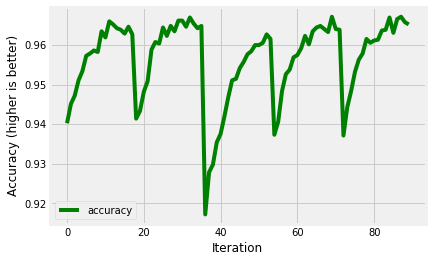

In [24]:
#Plot accuracy against max depth value
accuracy_matrix = pd.DataFrame.from_dict(accuracy_dict, orient='index')
accuracy_matrix.columns = ['accuracy']
accuracy_matrix.plot(color = 'green');
plt.xlabel('Iteration');
plt.ylabel('Accuracy (higher is better)');

In [25]:
decision_tree_model = cross_validation(X, y, DecisionTreeClassifier(max_depth = 14), vect_type = vect_list[1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') Metric Report

 -- Accuracy -- 
0.9649824569295129

 -- Confusion Matrix -- 
[[4444   72]
 [ 109  544]]

 -- Classification Report -- 
   precision    recall  fl-score
0   0.976069  0.984143  0.980024
1   0.881742  0.834063  0.854268

Note: we do not print the average "support" values as it is meaningless. We need to refer to the confusion matrix sum above


#### (iii) Random Forest Classifier

#### For a random forest model, we typically want to optimize the max_depth and n_estimators hyperparameter. Here, the GridSearchCV function becomes useful to find the optimal settings for these parameters as we want to avoid too many nested loops. 

In [26]:
print(dt.now())
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)

for i in range(len(vect_list)):
    X_train_dtm = vect_list[i].fit_transform(X_train)
    X_test_dtm =  vect_list[i].transform(X_test)
    param_grid = {'max_depth': np.arange(3, 21), 'n_estimators': np.arange(3, 21)}

    forest = GridSearchCV(RandomForestClassifier(), param_grid)
    y_true = np.array(y_test)
    forest.fit(X_train_dtm, y_train)
    forest_preds = forest.predict_proba(X_test_dtm)[:, 1]
    forest_performance = roc_auc_score(y_true, forest_preds)
    print('\n Searching for vect_type: ' + str(i))
    print('RandomForest: Area under the ROC curve = {}'.format(forest_performance))

    print(forest.best_params_)
    
print(dt.now())

2018-07-26 00:26:36.067819

 Searching for vect_type: 0
RandomForest: Area under the ROC curve = 0.9671694641164333
{'max_depth': 19, 'n_estimators': 8}

 Searching for vect_type: 1
RandomForest: Area under the ROC curve = 0.8931968995706241
{'max_depth': 20, 'n_estimators': 4}

 Searching for vect_type: 2
RandomForest: Area under the ROC curve = 0.9655606981542407
{'max_depth': 20, 'n_estimators': 12}

 Searching for vect_type: 3
RandomForest: Area under the ROC curve = 0.9617130429933641
{'max_depth': 18, 'n_estimators': 12}

 Searching for vect_type: 4
RandomForest: Area under the ROC curve = 0.9039619695533375
{'max_depth': 20, 'n_estimators': 4}
2018-07-26 00:34:34.941571


In [27]:
random_forest_model = cross_validation(X, y, RandomForestClassifier(max_depth = 19, n_estimators = 8), vect_type = vect_list[0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Metric Report

 -- Accuracy -- 
0.9690458518885041

 -- Confusion Matrix -- 
[[4514    2]
 [ 158  495]]

 -- Classification Report -- 
   precision    recall  fl-score
0   0.966216  0.999554  0.982582
1   0.996072  0.759377  0.860570

Note: we do not print the average "support" values as it is meaningless. We need to refer to the confusion matrix sum above


#### We can see that the naive bayes model is better at predicting true positives compared to the decision tree and random forest models.

### 4 - Diagnose False Negatives
#### Let's take a look at the spam messages that were misclassified as spam to determine if there are ways to engineer our features to improve the true positive rate. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 99)
X_train_dtm = vect_list[0].fit_transform(X_train)
X_test_dtm =  vect_list[0].transform(X_test)

nb_test = MultinomialNB(alpha = 0.1)
nb_test.fit(X_train_dtm, y_train)
y_pred_class = nb_test.predict(X_test_dtm)

diag_df = pd.concat([X_test, y_test], axis=1).reset_index().drop(columns = 'index').rename(columns = {'label': 'true_label'})
diag_df = pd.concat([diag_df, pd.Series(y_pred_class)], axis = 1).rename(columns = {0 : 'pred_label'})

diag_df = diag_df.loc[diag_df['true_label'] != diag_df['pred_label']].reset_index().drop(columns = 'index')
diag_df.loc[diag_df['true_label'] == 1, 'type'] = 'spam predicted as ham'
diag_df.loc[diag_df['pred_label'] == 1, 'type'] = 'ham predicted as spam'
diag_df.sort_values('type')

,text,true_label,pred_label,type
24,Can u get pic msgs to your phone?,0,1,ham predicted as spam
20,Customer place i will call you,0,1,ham predicted as spam
19,"Hi, Mobile no. &lt;#&gt; has added you in their contact list on www.fullonsms.com It s a great...",0,1,ham predicted as spam
6,"We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us",0,1,ham predicted as spam
17,Hey company elama po mudyadhu.,0,1,ham predicted as spam
8,26th OF JULY,0,1,ham predicted as spam
9,U WILL SWITCH YOUR FONE ON DAMMIT!!,0,1,ham predicted as spam
10,Anytime...,0,1,ham predicted as spam
11,Have you laid your airtel line to rest?,0,1,ham predicted as spam
13,K k:) sms chat with me.,0,1,ham predicted as spam


#### Two ways I might try to improve my feature engineering to increase my true positive rate are: 1) adding a column to the sparse matrix that flags a text containing a 5-digit number starting with 8. 2) adding a column that contains the polarity of the text using sentiment analysis. 

#### I have not figured out how to add a column to a sparse matrix. This is my next step. 

In [ ]:
print(dt.now())
# try ngrams = 3
# try just a sentiment analysis
# Punctuation?
# Cap vs non cap. 

#try beta score maker. 
#try bow transformer 
# tfdif'
#pipeline: countvectorizer and tfidf transformer 
#Decision tree - see how it branches 

#There is a function called cross_validate. 
#For cross validation look at spread of distribution, not just average. 
#Use stratified kfold to maintain balance between test and train

#Features: text length, punctuation text length, exclamation marks. 